In [46]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
from models import *
import pandas as pd
import numpy as np
import seaborn as sns
from pathlib import Path
from torch.utils.data import DataLoader

### Modele wybrane do porównania:

#### 1. Prosta sieć neuronowa złożona z:
kilku bloków, zawierających:
- warstwę konwolucyjną
- funkcję aktywacji ReLU
- normalizację wsadową
- warstwę dropout (p = 0.2)
- warstwę poolingową typu Max

na końcu:
- warstwę poolingu adaptacyjnego z biblioteki PyTorch, która dostosowuje rozmiar map cech do ustalonego rozmiaru wyjściowego
- warstwę w pełni połączoną

Ta sieć została przetestowana 3-krotnie, przyjmując różne jej warianty:
- A. Wersja bazowa (liczba warstw: 3, liczba filtrów: 64, 128, 256)
- B. Wersja "głębsza" (liczba warstw: 4, liczba filtrów: 32, 64, 128, 256)
- C. Wersja "szersza" (liczba warstw: 3, liczba filtrów: 128, 256, 512)

#### 2. Model oparty o architekturę ResNet wytrenowaną od zera (w okrojonej formie, ponieważ zbiór danych jest dość prosty)
Dla porównania: ResNet18 składa się z 4 bloków (w każdym 2 bloki residualne), a nasz model składa się z 4 bloków (w każdym 1 blok residualny).

#### Każdy z modeli trenowany był:
- przez 20 epok
- z wykorzystaniem optymalizatora Adam (momentum=0.9)
- za pomocą funkcji straty Entropii Krzyżowej
- z wykorzystaniem współczynnika uczenia równego: 1e-3
- zastosowano harmonogram współczynnika uczenia: zmniejszenie wartości x10 po 5 epokach braku poprawy straty na zbiorze walidacyjnym
- zastosowano regularyzację w postaci normy L2 (lambda=1e-4) w celu zapobiegania przeuczeniu
- rozmiar mini-paczki danych: 256

#### Poniżej przedstawiono przebiegi uczenia dla każdego z modeli

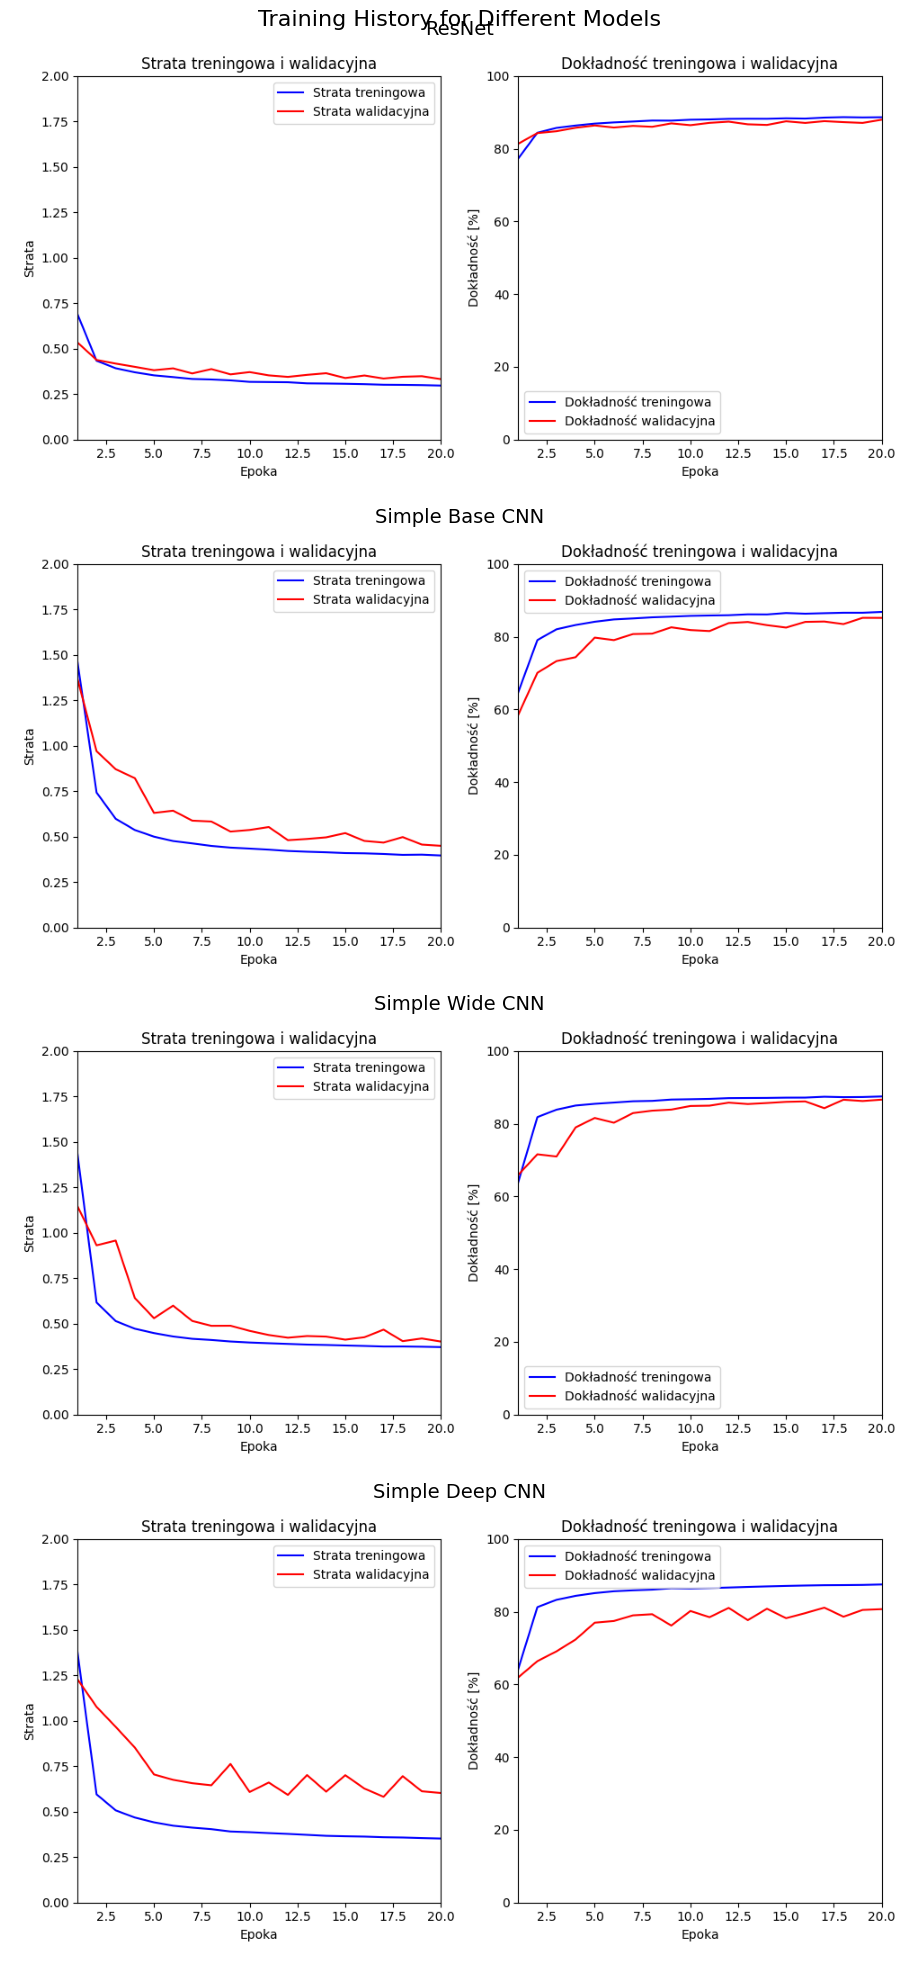

In [ ]:
# Wyświetlenie przebiegów uczenia modeli
resnet_wykres = "wykresy/training_history_resnet.png"
simple_base_wykres = "wykresy/training_history.png"
simple_wide_wykres = "wykresy/training_history_wide.png"
simple_deep_wykres = "wykresy/training_history_deep.png"

fig, axs = plt.subplots(4, 1, figsize=(20, 20))
plt.suptitle('Historia uczenia poszczególnych modeli', fontsize=16)

images = [resnet_wykres, simple_base_wykres, simple_wide_wykres, simple_deep_wykres]
titles = ['ResNet', 'Simple Base CNN', 'Simple Wide CNN', 'Simple Deep CNN']

for i, (img_path, title) in enumerate(zip(images, titles)):
    img = plt.imread(img_path)
    axs[i].imshow(img)
    axs[i].set_title(title, fontsize=14)
    axs[i].axis('off')

plt.tight_layout()
plt.show()

tralala omowienie trenowania

#### Wczytanie wytrenowanych wag wszystkich modeli w celu porównania

In [ ]:
resnet = ResNet(ResidualBlock, [1, 1, 1, 1], num_classes=47).to(device)
resnet.load_state_dict(torch.load("modele/resnet.pth"))

simple_base = SimpleCNN().to(device)
simple_base.load_state_dict(torch.load("modele/simple-base.pth"))

simple_wide = SimpleCNNWide().to(device)
simple_wide.load_state_dict(torch.load("modele/simple-wide.pth"))

simple_deep = SimpleCNNDeep().to(device)
simple_deep.load_state_dict(torch.load("modele/simple-deep.pth"))

models = [resnet, simple_base, simple_wide, simple_deep]

In [58]:
def ocen_model(model, dataloader, class_names, true_labels):
    print(f'Model: {model.__class__.__name__}')
    model.eval()
    all_preds = []
    
    with torch.no_grad():
        for inputs, _ in dataloader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
    
    y_pred = np.array(all_preds)
    acc = accuracy_score(true_labels, y_pred)
    print(f'Dokładność: {acc:.4f}')
    print(f'Raport klasyfikacji:\n{classification_report(true_labels, y_pred)}')
    
    cm = confusion_matrix(true_labels, y_pred)
    plt.figure(figsize=(15, 15))
    plt.title(f'Macierz pomyłek dla modelu {model.__class__.__name__}')
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names.values(), 
                yticklabels=class_names.values())
    plt.show()

#### Poniżej wczytuję dane testowe i przetwarzam je w taki sam sposób, jak dane treningowe.

In [39]:
# wczytanie danych testowych
df_test = pd.read_csv('emnist-balanced-test.csv', header=None)

# odwrócenie obrazów, żeby były pionowo, prawidłowo
for i in range(df_test.shape[0]):
    pixels = df_test.iloc[i,1:]
    
    image = pixels.values.reshape(28,28).T
    pixels = image.flatten()
    
    df_test.iloc[i,1:] = pixels

# podział danych na dane i etykiety + normalizacja
X_test = df_test.iloc[:, 1:].values / 255.0
y_test = df_test.iloc[:, 0].values

# wczytanie mapowania klas (nazw klas)
mapping = pd.read_csv('emnist-balanced-mapping.txt', delimiter=' ', header=None)
class_names = {mapping.iloc[i, 0]: chr(mapping.iloc[i, 1]) for i in range(len(mapping))}

# utworzenie datasetu i dataloadera
test_dataset = EMNISTDataset(X_test, y_test)
test_dataloader = DataLoader(test_dataset, batch_size=256, shuffle=False)

#### Dla każdego modelu uruchamiam funkcję ocen_model, która przeprowadza klasyfikację, mierzy dokładność, inne metryki oraz wyświetla macierz pomyłek w postaci mapy ciepła.

Model: ResNet
Dokładność: 0.8762
Raport klasyfikacji:
              precision    recall  f1-score   support

           0       0.62      0.74      0.68       400
           1       0.50      0.80      0.61       400
           2       0.93      0.85      0.89       400
           3       0.97      0.98      0.98       400
           4       0.96      0.92      0.94       400
           5       0.98      0.79      0.88       400
           6       0.95      0.92      0.94       400
           7       0.94      0.98      0.96       400
           8       0.94      0.93      0.93       400
           9       0.63      0.91      0.75       400
          10       0.98      0.94      0.96       400
          11       0.94      0.97      0.96       400
          12       0.96      0.95      0.96       400
          13       0.94      0.90      0.92       400
          14       0.98      0.96      0.97       400
          15       0.67      0.65      0.66       400
          16       0.89    

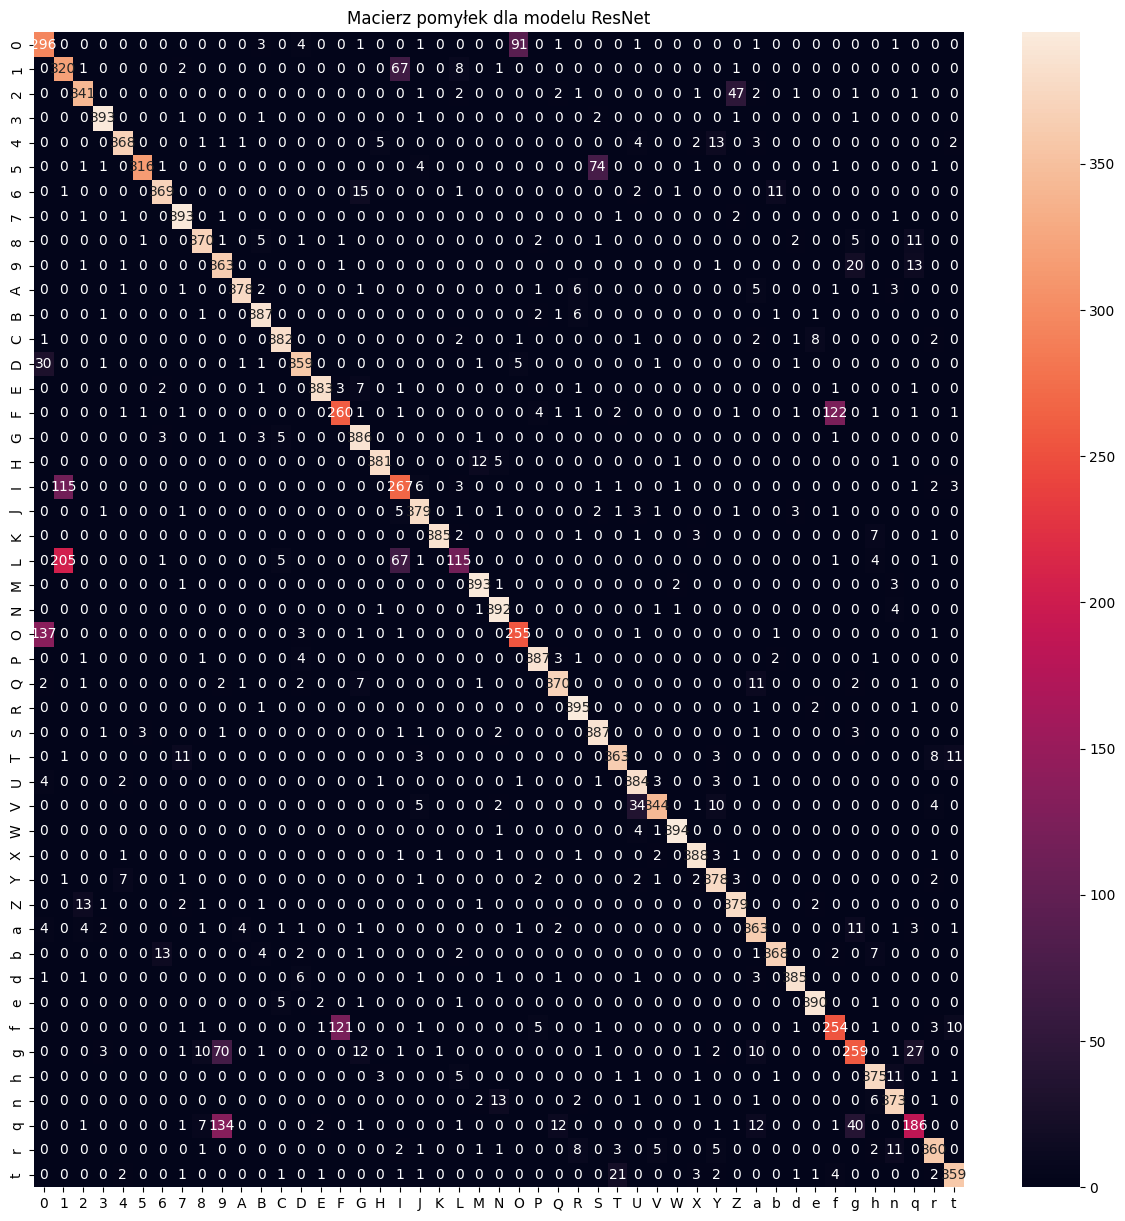

Model: SimpleCNN
Dokładność: 0.8476
Raport klasyfikacji:
              precision    recall  f1-score   support

           0       0.67      0.67      0.67       400
           1       0.62      0.32      0.43       400
           2       0.87      0.90      0.88       400
           3       0.97      0.96      0.96       400
           4       0.88      0.94      0.91       400
           5       0.95      0.80      0.87       400
           6       0.89      0.94      0.91       400
           7       0.92      0.97      0.94       400
           8       0.96      0.88      0.92       400
           9       0.67      0.74      0.71       400
          10       0.96      0.93      0.94       400
          11       0.98      0.92      0.95       400
          12       0.92      0.94      0.93       400
          13       0.95      0.82      0.88       400
          14       0.98      0.96      0.97       400
          15       0.74      0.45      0.56       400
          16       0.93 

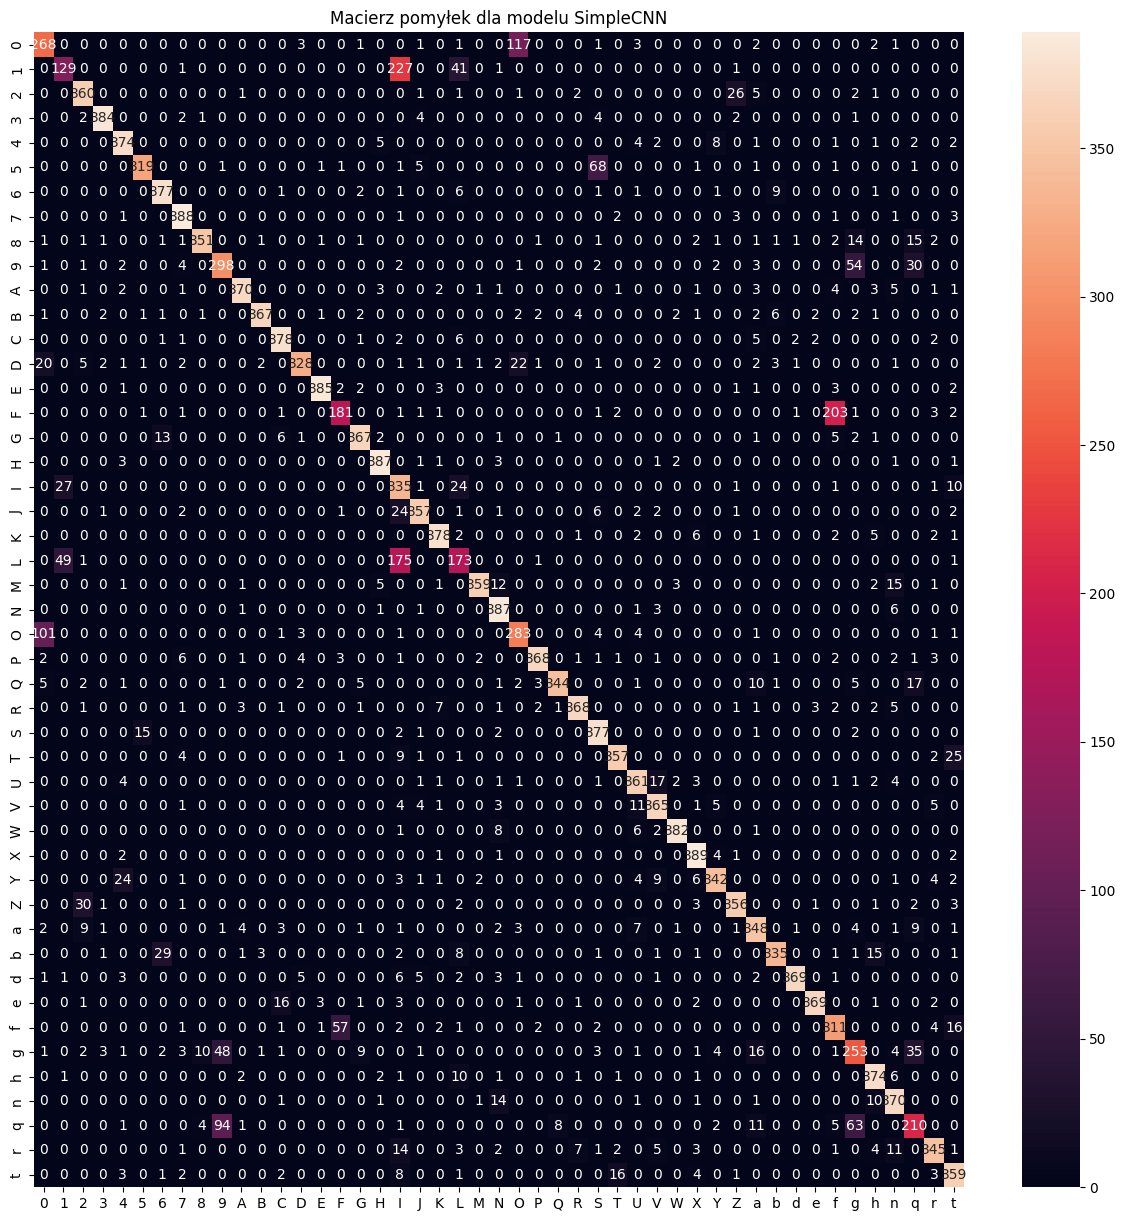

Model: SimpleCNNWide
Dokładność: 0.8627
Raport klasyfikacji:
              precision    recall  f1-score   support

           0       0.68      0.63      0.65       400
           1       0.55      0.67      0.60       400
           2       0.86      0.91      0.88       400
           3       0.99      0.99      0.99       400
           4       0.95      0.88      0.91       400
           5       0.92      0.88      0.90       400
           6       0.82      0.98      0.89       400
           7       0.97      0.97      0.97       400
           8       0.93      0.95      0.94       400
           9       0.69      0.67      0.68       400
          10       0.93      0.97      0.95       400
          11       0.97      0.94      0.96       400
          12       0.96      0.93      0.94       400
          13       0.94      0.85      0.89       400
          14       0.97      0.94      0.96       400
          15       0.66      0.61      0.64       400
          16       0

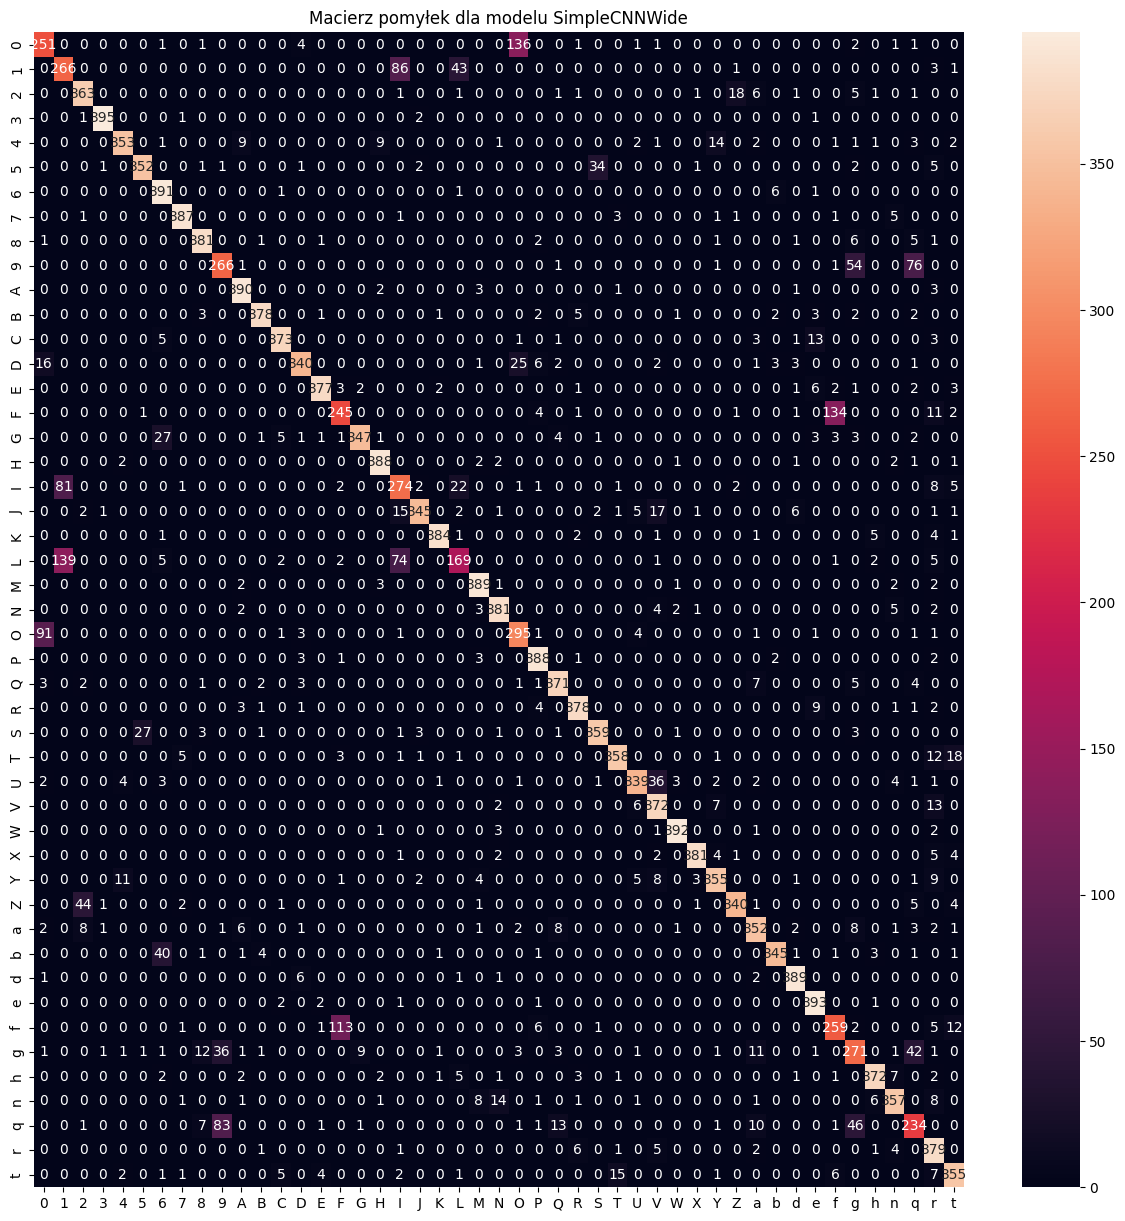

Model: SimpleCNNDeep
Dokładność: 0.8045
Raport klasyfikacji:
              precision    recall  f1-score   support

           0       0.61      0.32      0.42       400
           1       0.00      0.00      0.00       400
           2       0.88      0.90      0.89       400
           3       0.98      0.95      0.97       400
           4       0.89      0.92      0.90       400
           5       1.00      0.38      0.55       400
           6       0.89      0.90      0.89       400
           7       0.98      0.90      0.94       400
           8       0.95      0.87      0.91       400
           9       0.65      0.82      0.73       400
          10       0.92      0.96      0.94       400
          11       0.98      0.86      0.92       400
          12       0.73      0.96      0.83       400
          13       0.95      0.74      0.83       400
          14       0.99      0.92      0.95       400
          15       0.69      0.41      0.52       400
          16       0

c:\Users\matik\anaconda3\envs\ml\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\matik\anaconda3\envs\ml\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\matik\anaconda3\envs\ml\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


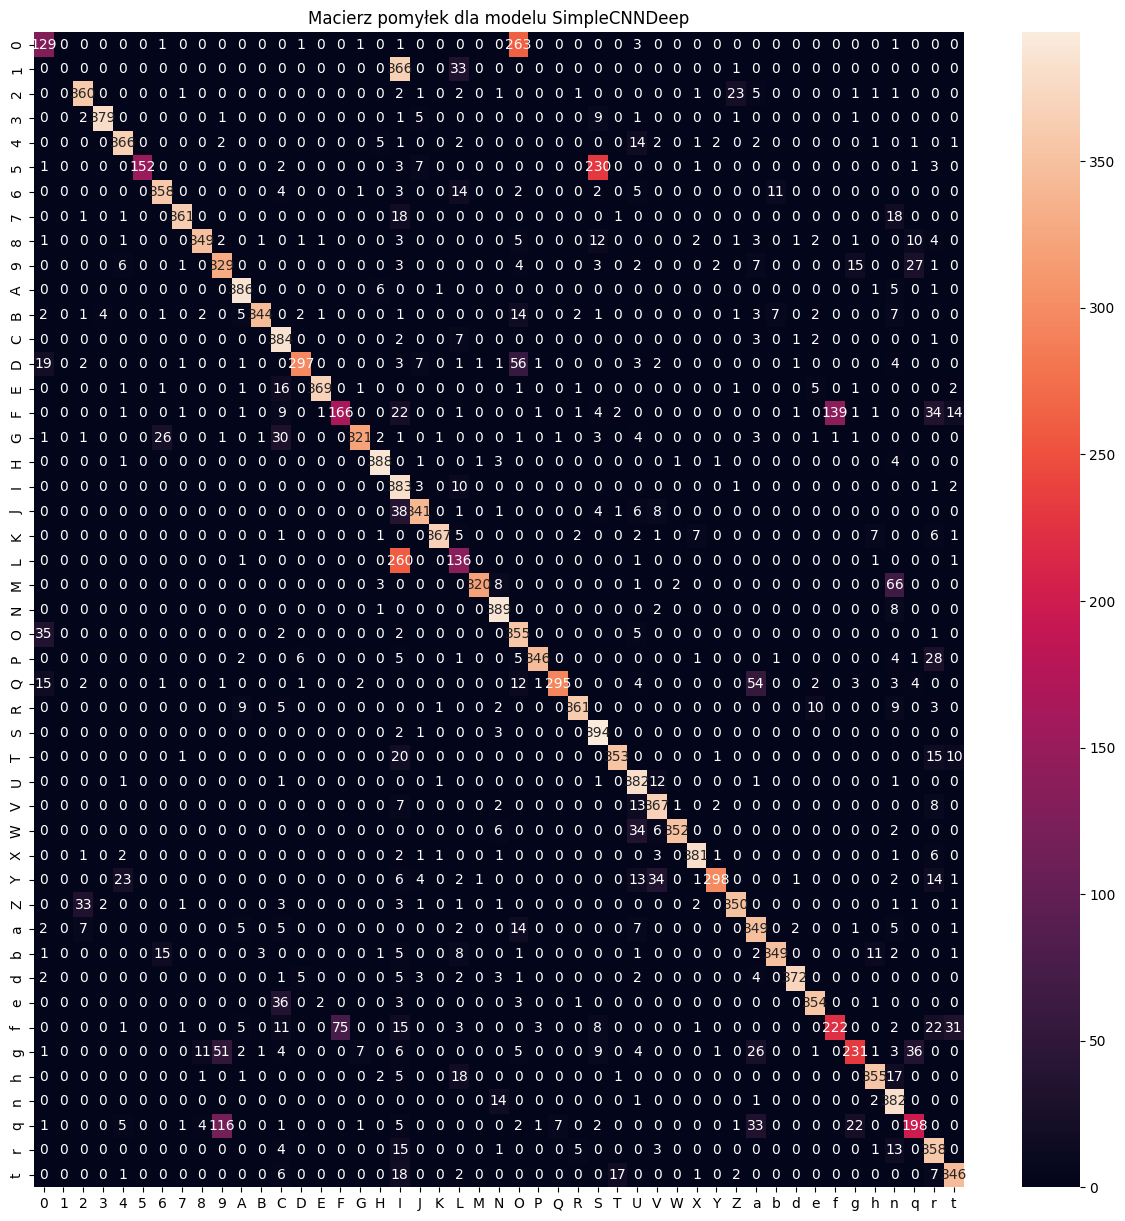

In [59]:
for model in models:
    ocen_model(model, test_dataloader, class_names, y_test)

### Wnioski

Najlepiej z powyższych poradziła sobie zmodyfikowana architektura ResNet, osiągając najwyższą dokładność: powyżej 87%. Dalej w kolejności od najlepszego: Prosta sieć konwolucyjna - szeroka, podstawowa i głęboka. Na mapie ciepła widać, że wszystkie modele myliły się najczęściej dla tych samych klas. Mała dokładność dla tych klas ma sens, ponieważ faktycznie są to zbliżone kształty, na przykład: (q i 9), (l i 1), (0 i O)... Niektóre z tych przykładów są trudne do odróżnienia nawet dla człowieka.

#### Poniżej wyświetlę predykcje modeli dla najgorzej rozpoznawanych przykładów.

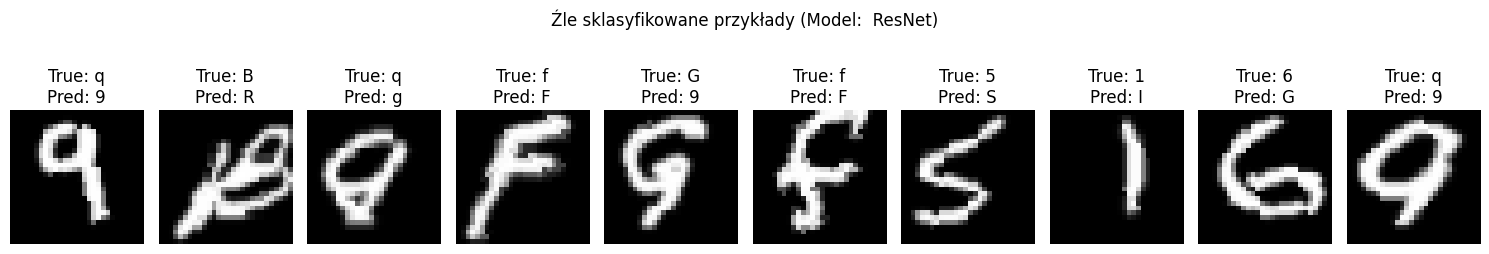

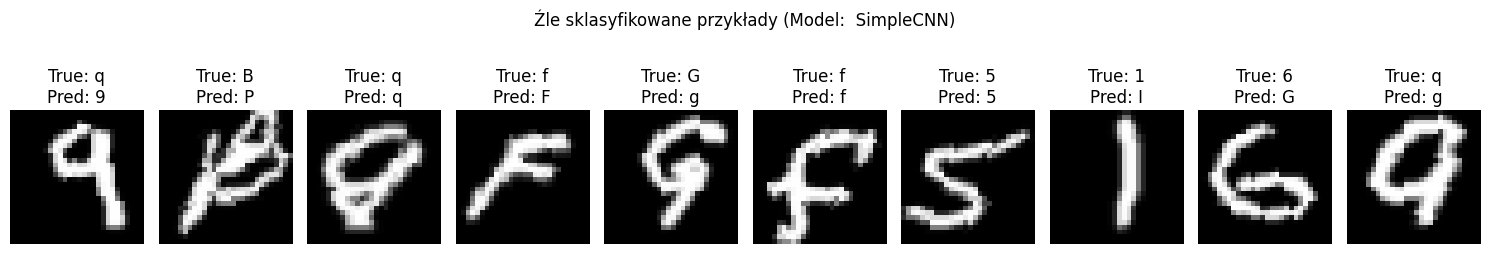

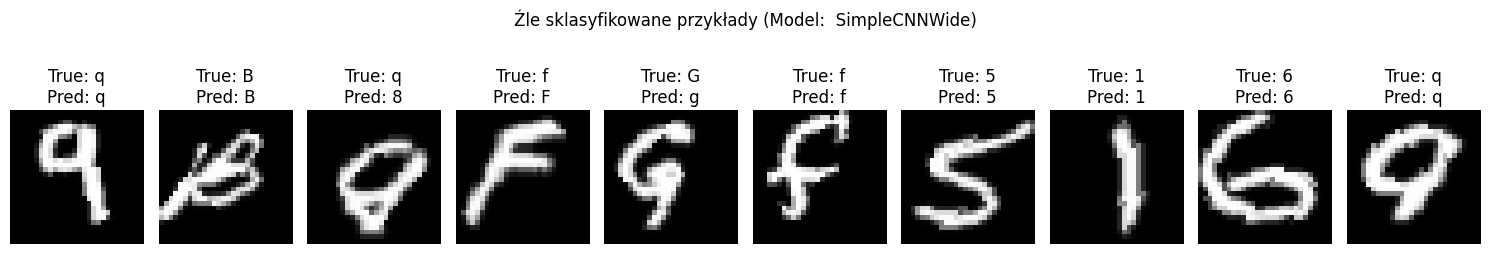

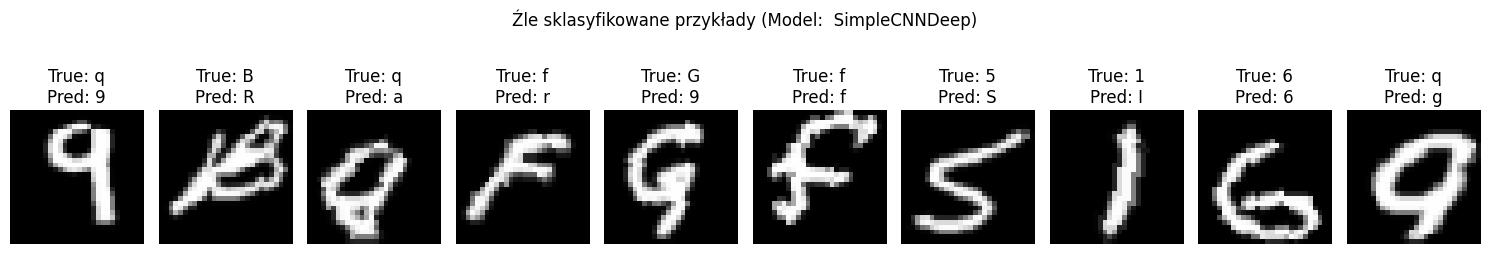

In [ ]:
misclassified_indices = None  # Do przechowywania indeksów źle sklasyfikowanych przykładów

for model_idx, model in enumerate(models):
    model.eval()

    # Weź batch danych z dataloadera
    inputs, labels = next(iter(test_dataloader))
    inputs, labels = inputs.to(device), labels.to(device)

    outputs = model(inputs)
    _, preds = torch.max(outputs, 1)

    # Wybierz błędne przykłady tylko dla pierwszego modelu
    if model_idx == 0:
        misclassified_indices = (preds != labels).nonzero(as_tuple=True)[0][:10] # 10 przykładów

    # Użyj tych samych indeksów dla pozostałych modeli
    misclassified_inputs = inputs[misclassified_indices]
    misclassified_labels = labels[misclassified_indices]
    misclassified_preds = preds[misclassified_indices]

    # Wizualizuj błędnie sklasyfikowane obrazy
    num_images = len(misclassified_inputs)
    if num_images > 0:
        fig, axes = plt.subplots(1, num_images, figsize=(15, 5))
        for i, ax in enumerate(axes.flat[:num_images]):
            img = misclassified_inputs[i].cpu().numpy().squeeze()
            true_label = class_names[misclassified_labels[i].item()]
            pred_label = class_names[misclassified_preds[i].item()]

            ax.imshow(img, cmap='gray')
            ax.set_title(f'True: {true_label}\nPred: {pred_label}')
            ax.axis('off')

        plt.suptitle(f"Źle sklasyfikowane przykłady (Model:  {model.__class__.__name__})", y=0.8)
        plt.tight_layout()
        plt.show()

#### Wnioski

Na podstawie powyższych przykładów ze zbioru testowego można zauważyć, że są one faktycznie trudne do rozpoznania, nawet przez człowieka. Przykłady albo są bardzo podobne do siebie, albo niestarannie narysowane, co znacznie utrudnia zadanie klasyfikacji. Podsumowując, jesteśmy zadowoleni z wyników projektu. Modele w satysfakcjonującym stopniu rozpoznają znaki. Mimo, że wartość dokładności nie jest idealna, to jednak w obliczu wielu trudnych do sklasyfikowania przykładów, wynik jest zdecydowanie zadowalający.